# Assessment 1

## Task 2: Image classification

In [1]:
# TensorFlow config to GPU
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus: 
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=15292)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(logical_gpus)
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")


from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

print()
print()

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.0
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
1 Physical GPU, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11885025967862399815
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16034824192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15088301213470768400
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


Num GPUs Available:  1


In [2]:
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np

# import sequential model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Rescaling
from tensorflow.keras.regularizers import l2

In [3]:
# function to plot the training/validation accuracies/losses.

def plot_learning(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    #axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['accuracy'])   
    axes[1].plot(history.history['val_accuracy'])
    #axes[1].grid()
    axes[1].legend(['accuracy','val_accuracy'])

In [4]:
train_directory = pathlib.Path("blood_cell_data/TRAIN")
test_directory = pathlib.Path("blood_cell_data/TEST")

In [5]:
class_names = os.listdir(train_directory)
class_names

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

We have a dataset of blood cells. The dataset folder contains 2 subfolders, `TRAIN` and `TEST`. Each of those subfolder contains images of blood cells of 4 different classes: `EOSINOPHIL`, `LYMPHOCYTE`, `MONOCYTE`, `NEUTROPHIL`. The task is to build a classifier that can classify blood cells into one of the 4 classes using Convolutional Neural Networks.

In [6]:
# Count the number of images in Train directory
total = 0
for item in os.listdir(train_directory):
    print(item, len(list(train_directory.glob(item + '/*'))))
    total += len(list(train_directory.glob(item + '/*')))

print("Total number of Training images: ", total)

print()

# Count the number of images in Test directory
total = 0
for item in os.listdir(test_directory):
    print(item, len(list(test_directory.glob(item + '/*'))))
    total += len(list(test_directory.glob(item + '/*')))

print("Total number of Test images: ", total)

EOSINOPHIL 2497
LYMPHOCYTE 2483
MONOCYTE 2478
NEUTROPHIL 2499
Total number of Training images:  9957

EOSINOPHIL 13
LYMPHOCYTE 6
MONOCYTE 4
NEUTROPHIL 48
Total number of Test images:  71


We have in total 9957 images in the training set and 71 images in the test set.

In [7]:
all_images = list(train_directory.glob("EOSINOPHIL/*"))
print(all_images[0])
img = plt.imread(all_images[0])
img.shape

blood_cell_data\TRAIN\EOSINOPHIL\_0_1169.jpeg


(240, 320, 3)

Each image is 240x320 pixels in RGB.

CNN (Convolutional Neural Network) is a class of deep neural networks, most commonly applied to analyzing visual imagery. CNNs use a variation of multilayer perceptrons designed to require minimal preprocessing. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on their shared-weights architecture and translation invariance characteristics. They have applications in image and video recognition, recommender systems, image classification, medical image analysis, natural language processing, and financial time series.

Since it is a deep neural network, it is very easy to overfit the data. To avoid overfitting, we will use data augmentation. Data augmentation is a technique to artificially increase the size of a training dataset by creating modified versions of images in the dataset. The modified images are created by a series of random transforms such as random horizontal flips, random vertical flips, random rotations, random translations, and more. This is a very useful technique to prevent overfitting. We will use the `ImageDataGenerator` class from Keras to perform data augmentation.

In [8]:
# Create generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
# Flow image data
train_images=train_generator.flow_from_directory(
    directory=train_directory,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_directory(
    directory=train_directory,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_directory(
    directory=test_directory,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [10]:
# get the number of classes
num_classes = len(class_names)

model = Sequential([Rescaling(1./1., input_shape=(224, 224,3))])

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (120, 160, 32)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation = "softmax"))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

A CNN is a type of neural network that is trained on image data. CNNs are used to classify images into predefined classes. CNNs are very effective in image classification tasks. 

Creating a CNN involves the following steps:
- Convolution
- Pooling
- Flattening
- Full connection

Convolution is the first step in a CNN. In this step, we create feature maps. A feature map is the result of a convolution operation between an input image and a filter. A filter is a small matrix that is used to extract features from an image. The filter is applied to the image by sliding it across the image. The filter is applied to every part of the image. The result of the convolution operation is called a feature map. The filter is applied to the image multiple times to create multiple feature maps. The number of feature maps created is equal to the number of filters used. The feature maps are stacked together to form a single tensor, which is called the output of the convolution operation. The output of the convolution operation is also called the activation map. The activation map is the result of applying the ReLU activation function to the convolution output.

Pooling is the next step in a CNN. In this step, we reduce the spatial size of the feature maps created in the convolution step. Pooling is performed on each feature map separately. The most common type of pooling operation is max pooling. In max pooling, we slide a pooling filter (also called pooling window) across the feature map and select the maximum value within the window. The result of the max pooling operation is a pooled feature map. The pooling filter is applied to every part of the feature map to create the pooled feature map. The size of the pooling filter is usually 2x2. The most common type of pooling filter is a 2x2 filter. The stride of the pooling filter is usually equal to the size of the filter. The most common stride is 2. The result of the max pooling operation is a feature map that is 1/4th the size of the original feature map.

Flattening is the third step in a CNN. In this step, we convert the pooled feature maps into a long vector that will be the input of the fully connected layers in the neural network. The flattened vector is a 1D vector that contains all the information about the image. The flattened vector is passed as input to the fully connected layers of the neural network.

Full connection is the last step in a CNN. In this step, we add one or more fully connected layers to the neural network. The fully connected layers are used to classify the images. The output of the fully connected layers is the result of the CNN.

The following diagram shows the architecture of a CNN:

![cnn](https://miro.medium.com/max/1100/1*kkyW7BR5FZJq4_oBTx3OPQ.png)

Since we are using the Keras library, we don't have to implement the CNN from scratch. We can use the `Sequential` class to initialize the neural network. We can add the different layers of the CNN one by one using the `add` method. We can add the convolutional layer using the `Conv2D` class. We can add the pooling layer using the `MaxPooling2D` class. We can add the flattening layer using the `Flatten` class. We can add the fully connected layer using the `Dense` class. We can add the output layer using the `Dense` class. We can compile the CNN using the `compile` method. We can train the CNN on the training set and evaluate it on the test set using the `fit` and `evaluate` methods.

The `Conv2D` class creates a convolutional layer. The first parameter is the number of feature detectors (also called feature maps or feature channels). The second parameter is the shape of the feature detector. The third parameter is the input shape of the images. The fourth parameter is the activation function. We will use the `relu` activation function. The `relu` activation function is the most common activation function used in CNNs. The `relu` activation function is defined as:

$$ f(x) = max(0, x) $$
where $x$ is the input to the activation function.

The `MaxPooling2D` class creates a pooling layer. The first parameter is the size of the pooling filter. The second parameter is the stride of the pooling filter. The most common size of the pooling filter is 2x2. The most common stride is 2.

The `Flatten` class creates a flattening layer. This layer is used to convert the pooled feature maps into a long vector that will be the input of the fully connected layers.

The `Dense` class creates a fully connected layer in the neural network. The first parameter is the number of nodes in the fully connected layer. The second parameter is the activation function. We will use the `relu` activation function. The `relu` activation function is the most common activation function used in CNNs. The `relu` activation function is defined as:

$$ f(x) = max(0, x) $$
where $x$ is the input to the activation function.

The `Dense` class creates the output layer of the neural network. The first parameter is the number of nodes in the output layer. Since we have 4 classes, the number of nodes in the output layer is 4. The second parameter is the activation function. We will use the `softmax` activation function. The `softmax` activation function is used in the output layer of a neural network with more than 2 classes. The `softmax` activation function is defined as:

$$ f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}} $$
where $x_i$ is the input to the activation function and $n$ is the number of nodes in the output layer.

The `compile` method compiles the CNN. The first parameter is the optimizer. We will use the `adam` optimizer. The `adam` optimizer is an advanced version of the stochastic gradient descent algorithm. The `adam` optimizer is very efficient and effective. The `adam` optimizer is the most common optimizer used to train CNNs. The second parameter is the loss function. We will use the `categorical_crossentropy` loss function. The `categorical_crossentropy` loss function is the most common loss function used to train CNNs. The `categorical_crossentropy` loss function is defined as:

$$ L = -\sum_{i=1}^{n} y_i \log(p_i) $$
where $y_i$ is the target value and $p_i$ is the predicted value.

The `fit` method trains the CNN on the training set. The first parameter is the training set. The second parameter is the target values of the training set. The third parameter is the number of epochs. We will train the CNN for 25 epochs. The fourth parameter is the batch size. We will use a batch size of 32. The `evaluate` method evaluates the performance of the CNN on the test set. The first parameter is the test set. The second parameter is the target values of the test set.

Now, since we are training the model with 100 epochs, it will take a lot of time to train the model. This can be solved using Early Stopping. Early Stopping is a technique used to stop the training of the model when the performance of the model on the validation set starts to decrease. We can use the `EarlyStopping` class to implement Early Stopping. The `EarlyStopping` class has the following parameters:
- `monitor`: The quantity to be monitored. We will monitor the `val_loss` quantity.
- `patience`: The number of epochs with no improvement after which training will be stopped. We will use a patience of 5.
- `restore_best_weights`: Whether to restore model weights from the epoch with the best value of the monitored quantity. We will use `True`.

In [12]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=   5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
249/249 [==============================] - 29s 99ms/step - loss: 1.1925 - accuracy: 0.4090 - val_loss: 0.9422 - val_accuracy: 0.5284
Epoch 2/100
249/249 [==============================] - 24s 96ms/step - loss: 0.7941 - accuracy: 0.6133 - val_loss: 0.5036 - val_accuracy: 0.7270
Epoch 3/100
249/249 [==============================] - 23s 92ms/step - loss: 0.4634 - accuracy: 0.7609 - val_loss: 0.2709 - val_accuracy: 0.8743
Epoch 4/100
249/249 [==============================] - 30s 121ms/step - loss: 0.2841 - accuracy: 0.8795 - val_loss: 0.2268 - val_accuracy: 0.8854
Epoch 5/100
249/249 [==============================] - 31s 124ms/step - loss: 0.1923 - accuracy: 0.9158 - val_loss: 0.1985 - val_accuracy: 0.9231
Epoch 6/100
249/249 [==============================] - 29s 116ms/step - loss: 0.1652 - accuracy: 0.9317 - val_loss: 0.1343 - val_accuracy: 0.9367
Epoch 7/100
249/249 [==============================] - 27s 108ms/step - loss: 0.1128 - accuracy: 0.9578 - val_loss: 0.1031 - va

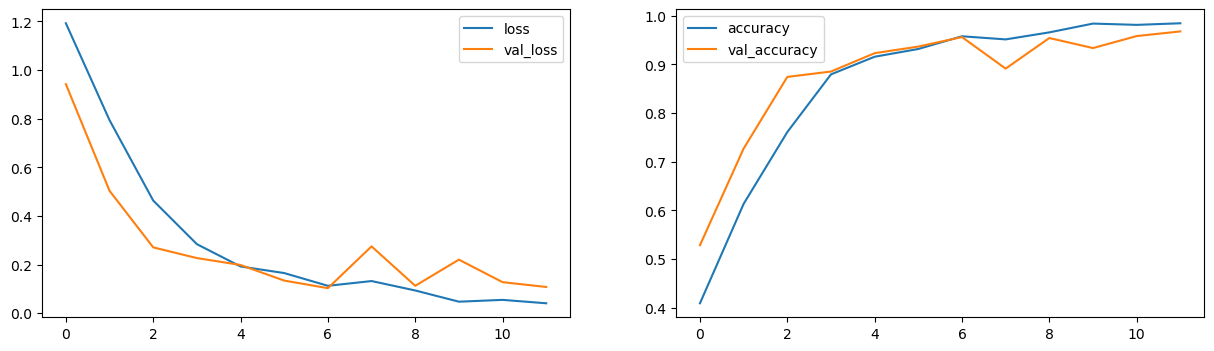

In [13]:
plot_learning(history)

In [14]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_images, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`

print()
print("Generate predictions")
predictions = model.predict(test_images[0])
print("predictions shape:", predictions.shape)
print("actual shape : ", test_images[0][1].shape)

Evaluate on test data
3/3 [==============================] - 0s 135ms/step - loss: 0.4362 - accuracy: 0.8732
test loss, test acc: [0.4361788332462311, 0.8732394576072693]

Generate predictions
predictions shape: (32, 4)
actual shape :  (32, 4)
